[Implementation from this tutorial](https://medium.com/@nubyra/parameter-efficient-fine-tuning-peft-of-bert-base-model-to-predict-medical-diagnosis-5086a1828f4b)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments, pipeline
from peft import PeftModel, PeftConfig, LoraConfig, TaskType, get_peft_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import os

In [2]:
model_name = "allegro/herbert-base-cased"
device = "mps"

In [ ]:
data_path = "all_texts.csv"
df = pd.read_csv(data_path)

print("First few entries:")
df.head()

First few entries:


,text,label
0,"Lakier roweru bardzo kiepskiej jakości , robią...",Negative
1,Nie jestem zadowolony z zakupu . Przede wszyst...,Negative
2,Szukając klucze tej wielkości brał em dwa pod ...,Neutral
3,Długo szukała m odpowiedniego fotelika dla bar...,Neutral
4,Kupił em pociąg ( w zestawie kilka torów prost...,Negative


In [ ]:
class_counts = df['label'].value_counts()
print("\nClass Counts:")
print(class_counts)

min_count = class_counts.min()
print(f"\nMinimum class count: {min_count}")


Class Counts:
label
Neutral     150
Positive     83
Negative     67
Name: count, dtype: int64

Minimum class count: 67


In [ ]:
random_seed = 42

df_balanced = df.groupby('label').apply(lambda x: x.sample(n=min_count, random_state=random_seed)).reset_index(drop=True)

print("\nBalanced Label Distribution:")
print(df_balanced['label'].value_counts(normalize=True) * 100)


Balanced Label Distribution:
label
Negative    33.333333
Neutral     33.333333
Positive    33.333333
Name: proportion, dtype: float64


/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_70250/3664909914.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label').apply(lambda x: x.sample(n=min_count, random_state=random_seed)).reset_index(drop=True)


In [ ]:
train_df, test_df = train_test_split(
    df_balanced, 
    test_size=0.2, 
    random_state=42, 
    # stratify=df['label']
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 160
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 41
    })
})

In [ ]:
print("Unique Labels:", sorted(df['label'].unique()))
print("Number of Labels:", len(sorted(df['label'].unique())))

print("Training Set Label Distribution:")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\nTest Set Label Distribution:")
print(test_df['label'].value_counts(normalize=True) * 100)      # 41.46341463414634

Unique Labels: ['Negative', 'Neutral', 'Positive']
Number of Labels: 3
Training Set Label Distribution:
label
Negative    35.00
Positive    33.75
Neutral     31.25
Name: proportion, dtype: float64

Test Set Label Distribution:
label
Neutral     41.463415
Positive    31.707317
Negative    26.829268
Name: proportion, dtype: float64


In [8]:
for entry in dataset['train'].select(range(3)):
    print('INPUT: {} \nOUTPUT: {}\n'.format(entry['text'], entry['label']))

INPUT: Duza częśc grupy zaliczyła w kolokwiach . 
OUTPUT: Positive

INPUT: Klawiaturę otrzymał em , rozpakował em , podłączył em , zainstalował em soft pobrany ze strony Razer . Windows 7 widzi klawiaturę poprawnie i instaluje ją gładko . Niestety oprogramowanie Razer nie rozpoznaje własnej klawiatury . Nie pomaga przepinanie do innych portów USB , wielokrotny restart , ani odpięcie innych urządzeń USB od komputera . W dodatku soft jest zaprojektowany tak bezmyślnie , że dopóki nie wykryje klawiatury , nie można nawet kliknąć ikony pomocy , przeczytać dokumentacji ani zrobić nic innego . Bez tego oprogramowania nie można skonfigurować dodatkowych klawiszy ani korzystać z żadnych innych funkcji klawiatury . Gdyby m mógł tej klawiatury używać , narzekał by m na zbyt twarde klawisze i na to , że między obudową a dolnymi klawiszami mini - padu ( który sam w sobie jest genialnym pomysłem , nie tylko do gier ! ) zieje szeroka szczelina , przez którą widać płytkę drukowaną pod spodem . Takie 

In [ ]:
train_counts = pd.DataFrame({'Diagnosis': train_df['label']})
train_counts = train_counts.groupby('Diagnosis').size().reset_index(name='train_set')

test_counts = pd.DataFrame({'Diagnosis': test_df['label']})
test_counts = test_counts.groupby('Diagnosis').size().reset_index(name='test_set')

display(train_counts.merge(test_counts, on='Diagnosis'))

,Diagnosis,train_set,test_set
0,Negative,56,11
1,Neutral,50,17
2,Positive,54,13


In [10]:
sorted_labels = sorted(set(df['label']))
label2id = {label: idx for idx, label in enumerate(sorted_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)

Label to ID mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}
ID to Label mapping: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [ ]:

tokenizer = AutoTokenizer.from_pretrained(model_name)

foundation_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

classifier = pipeline("text-classification", model=foundation_model, tokenizer=tokenizer, device=device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("Evaluating foundation model before fine-tuning...")

test_encodings = tokenizer(test_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")

foundation_model.to(device)
test_encodings = {k: v.to(device) for k, v in test_encodings.items()}

with torch.no_grad():
    outputs = foundation_model(**test_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

# Calculate accuracy
test_labels = test_df['label'].map(label2id).values
foundation_accuracy = round(np.mean(predictions == test_labels) * 100, 2)
print(f"Foundation Model Accuracy: {foundation_accuracy}%")

Evaluating foundation model before fine-tuning...
Foundation Model Accuracy: 29.27%


In [13]:
print("Number of Labels in Model:", foundation_model.config.num_labels)

Number of Labels in Model: 3


In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    r=64, 
    lora_alpha=1, 
    lora_dropout=0.1
)

peft_model = get_peft_model(foundation_model, lora_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [15]:
peft_model.print_trainable_parameters()

trainable params: 2,361,603 || all params: 126,806,790 || trainable%: 1.8624


In [ ]:
def preprocess_function(examples):
    """Preprocess the dataset by returning tokenized examples."""
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True)
    tokens['labels'] = [label2id[l] for l in examples["label"]]
    return tokens

tokenized_ds = dataset.map(preprocess_function, batched=True, remove_columns=["label"])

print(tokenized_ds)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 160
    })
    test: Dataset({
        features: ['text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 41
    })
})


In [17]:
print("A tokenized training input example:")
# text
print(tokenized_ds["train"][0]["text"])
# tokens
print(tokenized_ds["train"][0]["input_ids"])
print("\n")
print("A tokenized training label example:")
print(tokenized_ds["train"][0]["labels"])

A tokenized training input example:
Duza częśc grupy zaliczyła w kolokwiach .
[0, 3491, 2163, 2300, 49518, 4106, 11295, 4061, 1019, 6167, 3680, 2207, 1899, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = (predictions == labels).mean() * 100
    return {"accuracy": accuracy}

trainer = Trainer(
    model=peft_model,
    args=TrainingArguments(
        output_dir="herbert-lora",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=15,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='logs',
        logging_steps=10,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/300 [00:00<?, ?it/s]

{'loss': 1.0977, 'grad_norm': 8.038151741027832, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.5}
{'loss': 1.1097, 'grad_norm': 7.334142684936523, 'learning_rate': 1.866666666666667e-05, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1145750284194946, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 3.0808, 'eval_samples_per_second': 13.308, 'eval_steps_per_second': 1.948, 'epoch': 1.0}
{'loss': 1.0931, 'grad_norm': 4.726180076599121, 'learning_rate': 1.8e-05, 'epoch': 1.5}
{'loss': 1.1174, 'grad_norm': 6.743591785430908, 'learning_rate': 1.7333333333333336e-05, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1145315170288086, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.06, 'eval_samples_per_second': 19.903, 'eval_steps_per_second': 2.913, 'epoch': 2.0}
{'loss': 1.1235, 'grad_norm': 5.9114484786987305, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.5}
{'loss': 1.1021, 'grad_norm': 2.1796929836273193, 'learning_rate': 1.6000000000000003e-05, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1114311218261719, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.0869, 'eval_samples_per_second': 19.646, 'eval_steps_per_second': 2.875, 'epoch': 3.0}
{'loss': 1.1024, 'grad_norm': 3.3069138526916504, 'learning_rate': 1.5333333333333334e-05, 'epoch': 3.5}
{'loss': 1.1071, 'grad_norm': 9.022171020507812, 'learning_rate': 1.4666666666666666e-05, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1092479228973389, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.0967, 'eval_samples_per_second': 19.554, 'eval_steps_per_second': 2.862, 'epoch': 4.0}
{'loss': 1.1072, 'grad_norm': 4.479854106903076, 'learning_rate': 1.4e-05, 'epoch': 4.5}
{'loss': 1.1134, 'grad_norm': 9.349715232849121, 'learning_rate': 1.3333333333333333e-05, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.108566403388977, 'eval_accuracy': 34.146341463414636, 'eval_runtime': 2.3015, 'eval_samples_per_second': 17.814, 'eval_steps_per_second': 2.607, 'epoch': 5.0}
{'loss': 1.108, 'grad_norm': 3.1446948051452637, 'learning_rate': 1.2666666666666667e-05, 'epoch': 5.5}
{'loss': 1.1059, 'grad_norm': 6.404232025146484, 'learning_rate': 1.2e-05, 'epoch': 6.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.107526421546936, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.2814, 'eval_samples_per_second': 17.972, 'eval_steps_per_second': 2.63, 'epoch': 6.0}
{'loss': 1.0878, 'grad_norm': 3.2521848678588867, 'learning_rate': 1.1333333333333334e-05, 'epoch': 6.5}
{'loss': 1.0878, 'grad_norm': 4.290170192718506, 'learning_rate': 1.0666666666666667e-05, 'epoch': 7.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.107470154762268, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.1493, 'eval_samples_per_second': 19.076, 'eval_steps_per_second': 2.792, 'epoch': 7.0}
{'loss': 1.0969, 'grad_norm': 4.0294060707092285, 'learning_rate': 1e-05, 'epoch': 7.5}
{'loss': 1.0746, 'grad_norm': 6.737278461456299, 'learning_rate': 9.333333333333334e-06, 'epoch': 8.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1066749095916748, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.0354, 'eval_samples_per_second': 20.143, 'eval_steps_per_second': 2.948, 'epoch': 8.0}
{'loss': 1.0812, 'grad_norm': 4.5443315505981445, 'learning_rate': 8.666666666666668e-06, 'epoch': 8.5}
{'loss': 1.1059, 'grad_norm': 6.583975791931152, 'learning_rate': 8.000000000000001e-06, 'epoch': 9.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.106225848197937, 'eval_accuracy': 34.146341463414636, 'eval_runtime': 2.2882, 'eval_samples_per_second': 17.918, 'eval_steps_per_second': 2.622, 'epoch': 9.0}
{'loss': 1.1022, 'grad_norm': 2.8471648693084717, 'learning_rate': 7.333333333333333e-06, 'epoch': 9.5}
{'loss': 1.0954, 'grad_norm': 7.145320415496826, 'learning_rate': 6.666666666666667e-06, 'epoch': 10.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.106073260307312, 'eval_accuracy': 29.268292682926827, 'eval_runtime': 2.0384, 'eval_samples_per_second': 20.114, 'eval_steps_per_second': 2.943, 'epoch': 10.0}
{'loss': 1.088, 'grad_norm': 2.246035575866699, 'learning_rate': 6e-06, 'epoch': 10.5}
{'loss': 1.1016, 'grad_norm': 5.084918022155762, 'learning_rate': 5.333333333333334e-06, 'epoch': 11.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1062721014022827, 'eval_accuracy': 34.146341463414636, 'eval_runtime': 2.0376, 'eval_samples_per_second': 20.122, 'eval_steps_per_second': 2.945, 'epoch': 11.0}
{'loss': 1.1058, 'grad_norm': 3.4651355743408203, 'learning_rate': 4.666666666666667e-06, 'epoch': 11.5}
{'loss': 1.0866, 'grad_norm': 6.269768238067627, 'learning_rate': 4.000000000000001e-06, 'epoch': 12.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1063709259033203, 'eval_accuracy': 34.146341463414636, 'eval_runtime': 2.0522, 'eval_samples_per_second': 19.979, 'eval_steps_per_second': 2.924, 'epoch': 12.0}
{'loss': 1.1104, 'grad_norm': 4.502198696136475, 'learning_rate': 3.3333333333333333e-06, 'epoch': 12.5}
{'loss': 1.101, 'grad_norm': 6.497560977935791, 'learning_rate': 2.666666666666667e-06, 'epoch': 13.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.106364130973816, 'eval_accuracy': 34.146341463414636, 'eval_runtime': 1.9694, 'eval_samples_per_second': 20.819, 'eval_steps_per_second': 3.047, 'epoch': 13.0}
{'loss': 1.1066, 'grad_norm': 4.627597808837891, 'learning_rate': 2.0000000000000003e-06, 'epoch': 13.5}
{'loss': 1.0916, 'grad_norm': 4.474952697753906, 'learning_rate': 1.3333333333333334e-06, 'epoch': 14.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1062251329421997, 'eval_accuracy': 29.268292682926827, 'eval_runtime': 2.0952, 'eval_samples_per_second': 19.569, 'eval_steps_per_second': 2.864, 'epoch': 14.0}
{'loss': 1.1, 'grad_norm': 5.813303470611572, 'learning_rate': 6.666666666666667e-07, 'epoch': 14.5}
{'loss': 1.0889, 'grad_norm': 4.3653411865234375, 'learning_rate': 0.0, 'epoch': 15.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1062008142471313, 'eval_accuracy': 31.70731707317073, 'eval_runtime': 2.0518, 'eval_samples_per_second': 19.982, 'eval_steps_per_second': 2.924, 'epoch': 15.0}
{'train_runtime': 333.3763, 'train_samples_per_second': 7.199, 'train_steps_per_second': 0.9, 'train_loss': 1.0999935658772786, 'epoch': 15.0}


TrainOutput(global_step=300, training_loss=1.0999935658772786, metrics={'train_runtime': 333.3763, 'train_samples_per_second': 7.199, 'train_steps_per_second': 0.9, 'total_flos': 648883829145600.0, 'train_loss': 1.0999935658772786, 'epoch': 15.0})

In [ ]:
peft_herbert_model_path = "fine-tuned-peft-herbert-model-weights/"
peft_model.save_pretrained(peft_herbert_model_path)

for file_name in os.listdir(peft_herbert_model_path):
    file_size = os.path.getsize(os.path.join(peft_herbert_model_path, file_name))
    print(f"File Name: {file_name}; File Size: {file_size / 1024:.2f}KB")

File Name: adapter_model.safetensors; File Size: 9231.85KB
File Name: README.md; File Size: 4.98KB
File Name: adapter_config.json; File Size: 0.66KB


In [ ]:
print("Evaluating fine-tuned model...")

config = PeftConfig.from_pretrained(peft_herbert_model_path)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
model = PeftModel.from_pretrained(model, peft_herbert_model_path)

model.to(device)

eval_trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="allegro-bert-lora",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='logs',
        logging_steps=10,
        
    ),
    eval_dataset=tokenized_ds['test'],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

test_results = eval_trainer.evaluate()
print(test_results)

model_save_path = "final-fine-tuned-peft-herbert-model/"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

Evaluating fine-tuned model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.108566403388977, 'eval_model_preparation_time': 0.004, 'eval_accuracy': 34.146341463414636, 'eval_runtime': 2.0684, 'eval_samples_per_second': 19.822, 'eval_steps_per_second': 2.901}


('final-fine-tuned-peft-herbert-model/tokenizer_config.json',
 'final-fine-tuned-peft-herbert-model/special_tokens_map.json',
 'final-fine-tuned-peft-herbert-model/vocab.json',
 'final-fine-tuned-peft-herbert-model/merges.txt',
 'final-fine-tuned-peft-herbert-model/added_tokens.json',
 'final-fine-tuned-peft-herbert-model/tokenizer.json')

In [ ]:
predictions_output = trainer.predict(tokenized_ds["test"])

preds = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

predicted_labels = [id2label[pred] for pred in preds]
true_labels = [id2label[label] for label in labels]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_loader = DataLoader(
    tokenized_ds["test"],
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator
)

In [ ]:
predictions_output = eval_trainer.predict(tokenized_ds["test"])

preds = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

predicted_labels = [id2label[pred] for pred in preds]
true_labels = [id2label[label] for label in labels]

  0%|          | 0/6 [00:00<?, ?it/s]

/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_70250/3423536581.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, palette='viridis')


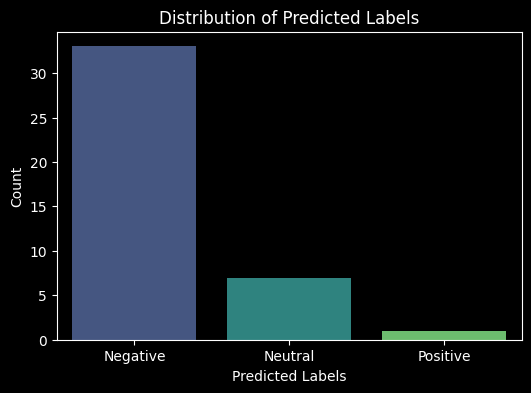

In [ ]:
pred_label_counts = pd.Series(predicted_labels).value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, palette='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.show()

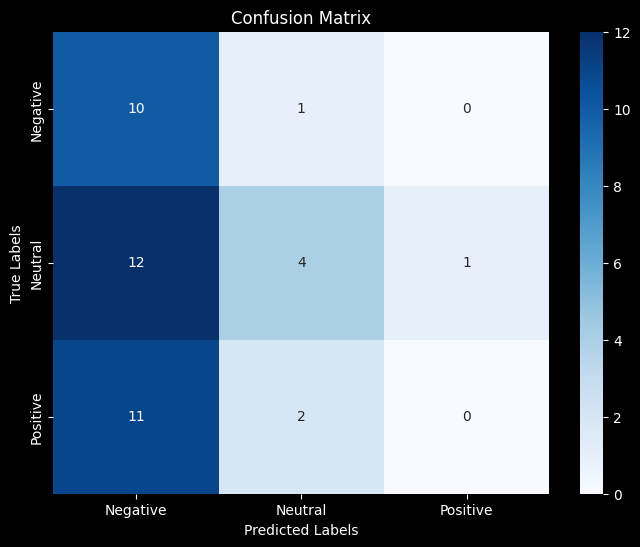

In [ ]:

cm = confusion_matrix(true_labels, predicted_labels, labels=sorted_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted_labels, yticklabels=sorted_labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

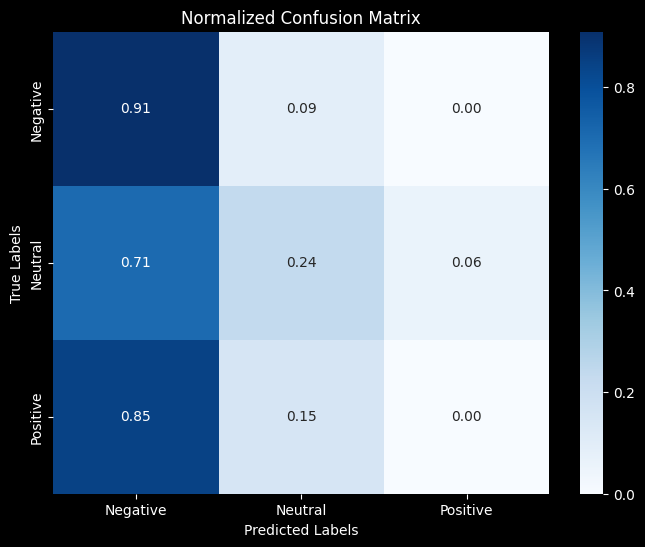

In [ ]:
cm_normalized = confusion_matrix(true_labels, predicted_labels, labels=sorted_labels, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=sorted_labels, yticklabels=sorted_labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=sorted_labels)
print(report)

              precision    recall  f1-score   support

    Negative       0.30      0.91      0.45        11
     Neutral       0.57      0.24      0.33        17
    Positive       0.00      0.00      0.00        13

    accuracy                           0.34        41
   macro avg       0.29      0.38      0.26        41
weighted avg       0.32      0.34      0.26        41



In [ ]:

def get_probabilities(logits):
    return F.softmax(torch.tensor(logits), dim=-1).numpy()

probabilities = get_probabilities(predictions_output.predictions)

for i in range(5):
    print(f"Example {i+1}:")
    print(f"Text: {test_df['text'].iloc[i]}")
    print(f"True Label: {true_labels[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print(f"Probabilities: {probabilities[i]}")
    print("-" * 50)

Example 1:
Text: Jesli sluchasz go na zajeciach i zrobisz w domu ze 2 zadanka , to powinienes bez problemow zaliczyc .
True Label: Neutral
Predicted Label: Neutral
Probabilities: [0.34296697 0.343393   0.31364006]
--------------------------------------------------
Example 2:
Text: Gdy je poprawiasz i przynosisz następnym razem , wyszukuje Ci kolejne błedy , a to co poprawił eś na dobrze , jest źle i miało być tak jak na poczatku .
True Label: Negative
Predicted Label: Negative
Probabilities: [0.3758983  0.28154638 0.34255534]
--------------------------------------------------
Example 3:
Text: UWAGA !
True Label: Negative
Predicted Label: Negative
Probabilities: [0.4006483  0.2778274  0.32152432]
--------------------------------------------------
Example 4:
Text: Z zaliczeniem nie ma raczej problemu .
True Label: Positive
Predicted Label: Negative
Probabilities: [0.39736384 0.30106956 0.30156654]
--------------------------------------------------
Example 5:
Text: Mało wytłumaczy , ale c

In [ ]:
def preprocess_function(examples):
    tokens = tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=512
    )
    tokens['labels'] = [label2id[l] for l in examples["label"]]
    return tokens

tokenized_ds = dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=dataset["train"].column_names
)

print(tokenized_ds)



Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 160
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 41
    })
})


Extracting embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


In [ ]:
def extract_embeddings(model, tokenizer, dataset, device, batch_size=16):
    model.eval()
    loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=DataCollatorWithPadding(tokenizer=tokenizer)
    )
    embeddings = []
    labels = []
    
    model_input_keys = tokenizer.model_input_names

    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting embeddings"):
            # Przygotowanie wejść
            inputs = {k: v.to(device) for k, v in batch.items() if k in model_input_keys}
            # Wywołanie modelu z output_hidden_states=True
            outputs = model(**inputs, output_hidden_states=True, return_dict=True)
            # Ukryte stany to krotka wszystkich warstw
            hidden_states = outputs.hidden_states
            # Pobranie ostatniego ukrytego stanu
            last_hidden_state = hidden_states[-1]  # Kształt: [batch_size, seq_length, hidden_size]
            # Wyodrębnienie reprezentacji [CLS]
            cls_embeddings = last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
            labels.extend(batch['labels'].cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    return embeddings, labels

test_embeddings, test_labels_ids = extract_embeddings(
    model, 
    tokenizer, 
    tokenized_ds["test"], 
    device=device, 
    batch_size=16
)

test_labels = [id2label[label_id] for label_id in test_labels_ids]

test_predicted_labels = [id2label[pred] for pred in preds]

In [36]:

pca = PCA(n_components=40, random_state=42)
embeddings_pca = pca.fit_transform(test_embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

df_visualization = pd.DataFrame({
    'TSNE-1': embeddings_tsne[:,0],
    'TSNE-2': embeddings_tsne[:,1],
    'True Label': test_labels,
    'Predicted Label': test_predicted_labels,
    'Text': test_df['text']
})

fig_true = px.scatter(
    df_visualization,
    x='TSNE-1',
    y='TSNE-2',
    color='True Label',
    hover_data=['True Label', 'Predicted Label', 'Text'],
    title='Przestrzeń Wektorowa Testowych Przypadków (Kolor: Prawdziwe Etykiety)',
    width=1200,
    height=600
)

fig_true.show()

fig_pred = px.scatter(
    df_visualization,
    x='TSNE-1',
    y='TSNE-2',
    color='Predicted Label',
    hover_data=['True Label', 'Predicted Label', 'Text'],
    title='Przestrzeń Wektorowa Testowych Przypadków (Kolor: Przewidywane Etykiety)',
    width=1200,
    height=600
)

fig_pred.show()

df_visualization['Correct'] = df_visualization['True Label'] == df_visualization['Predicted Label']

fig_correct = px.scatter(
    df_visualization,
    x='TSNE-1',
    y='TSNE-2',
    color='Correct',
    symbol='Correct',
    hover_data=['True Label', 'Predicted Label', 'Text'],
    title='Przestrzeń Wektorowa Testowych Przypadków (Zaznaczenie Poprawnych/Niepoprawnych)',
    width=1200,
    height=600
)

fig_correct.show()

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.

